<a href="https://colab.research.google.com/github/jlprieto/sandbox/blob/main/Health_Agregator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports and set up

In [1]:
# pip install filterpy

In [2]:
pip install fitbit

  Preparing metadata (setup.py) ... done
  Created wheel for fitbit: filename=fitbit-0.3.1-py3-none-any.whl size=13865 sha256=7a87ad996003d223ea657b0b3ee48c24ff96884baec17179ce6e239539e6b328
  Stored in directory: /root/.cache/pip/wheels/57/5b/7b/e89a168e43cca82107fe83494c86819348e17e2f9791b73df2
Successfully built fitbit


In [4]:
import re
import os
import csv
import json
import time
import glob
from datetime import datetime
from google.colab import drive
from google.colab import userdata
from xml.etree.ElementTree import iterparse

import math
import pandas as pd
import numpy as np
from scipy.signal import find_peaks
# from filterpy.kalman import KalmanFilter

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
%matplotlib inline

from bokeh.plotting import figure, output_notebook, show
from bokeh.models import DatetimeTickFormatter, NumeralTickFormatter
from bokeh.models import Span, Label, BoxAnnotation, Range1d
from bokeh.layouts import gridplot, column

# Enable Bokeh output in the notebook
output_notebook()

_REPROCESS_ = False

In [5]:
_DRIVE_MOUNT_ = userdata.get('_DRIVE_MOUNT_')
if not os.path.exists(_DRIVE_MOUNT_):
  drive.mount(_DRIVE_MOUNT_)

_HEALTH_ROOT_ = userdata.get('_HEALTH_ROOT_')
if not os.path.exists(_HEALTH_ROOT_):
  raise Exception("Health folder not found")

_APPLE_ROOT_ = os.path.join(_HEALTH_ROOT_, 'Apple')
if not os.path.exists(_APPLE_ROOT_):
  raise Exception("APPLE folder not found")

_GOOGLE_ROOT_ = os.path.join(_HEALTH_ROOT_, 'Google')
if not os.path.exists(_GOOGLE_ROOT_):
  raise Exception("Google folder not found")

_NUTRISENSE_ROOT_ = os.path.join(_HEALTH_ROOT_, 'Nutrisense')
if not os.path.exists(_NUTRISENSE_ROOT_):
  raise Exception("NUTRISENSE folder not found")

_LOSEIT_ROOT_ = os.path.join(_HEALTH_ROOT_, 'LoseIt')
if not os.path.exists(_LOSEIT_ROOT_):
  raise Exception("LoseIt folder not found")

_ABBOTT_ROOT_ = os.path.join(_HEALTH_ROOT_, 'Abbott')
if not os.path.exists(_ABBOTT_ROOT_):
  raise Exception("ABBOTT folder not found")

_PARSED_ROOT_ = os.path.join(_HEALTH_ROOT_, 'Parsed')
if not os.path.exists(_PARSED_ROOT_):
  raise Exception("Destination ('Parsed') folder not found")

_AUXILIARY_ROOT_ = os.path.join(_PARSED_ROOT_, 'auxiliary')
if not os.path.exists(_AUXILIARY_ROOT_):
  raise Exception("Auxiliary folder not found inside 'Parsed' folder")

Mounted at /content/drive


# Auxiliary functions

In [6]:
def find_latest_path(directory: str) -> str:
  """
  Finds the file or latest folder in a directory based on file timestamp

  Args:
    directory: The path to the directory

  Returns:
    The path to the latest file or folder
  """
  if not os.path.exists(directory):
    print(f"The folder {directory} does not exist")
    return None
  if not os.path.isdir(directory):
    print(f"The path {directory} is not a directory")
    return None

  files = [os.path.join(directory, f) for f in os.listdir(directory)]
  # files = [file_name for file_name in files if os.path.isfile(file_name)]
  if not files:
    print("No files found in the directory")
    return None
  latest_file = max(files, key=os.path.getmtime)
  return latest_file

In [7]:
def get_last_processed(source_name: str,
                            process_filepath: os.path = os.path.join(_AUXILIARY_ROOT_, 'last_processed.json')) -> str:
  """
  Gets the filename of the last processed file for a given source (i.e. Apple, Abbott,
  Nutrisense, LoseIt)

  Args:
    source_name: The name of the source can be one of:
                 Apple, Abbott, Nutrisense, LoseIt

    process_filepath: The path to the file that keeps track of the last
                processed file [Default: _AUXILIARY_ROOT_/last_processed.json]

  Returns:
    The path to the last processed file
  """
  if os.path.exists(process_filepath):
    with open(process_filepath, 'r') as f:
      last_processed = json.load(f)
    if source_name in last_processed:
      return last_processed[source_name]
  return None


In [8]:
def update_last_processed(source_name: str,
                               last_filename: str,
                               process_filepath: os.path = os.path.join(_AUXILIARY_ROOT_, 'last_processed.json')) -> None:
  """
  Updates the filename of the last processed file for a given source
  (i.e. Apple, Abbott, Nutrisense, LoseIt)

  Args:
    source_name: The name of the source can be one of:
                 Apple, Abbott, Nutrisense, LoseIt
    last_filename: The name of the file that was processed last.
    process_filepath: The path to the file that keeps track of the last
                processed file [Default: _AUXILIARY_ROOT_/last_processed.json]
  Returns:
    None
  """
  if os.path.exists(process_filepath):
    with open(process_filepath, 'r') as f:
      last_processed = json.load(f)
    last_processed[source_name] = last_filename
  else:
    print("WARNING: I can't find the filepath that stores the latest ",
          f"processed files. I create one in: {process_filepath}")
    last_processed = {source_name: last_filename}

  with open(process_filepath, 'w') as f:
    json.dump(last_processed, f, indent=4)

In [9]:
def identify_cgm_peaks(cgm: pd.DataFrame = None) -> pd.DataFrame:
  """
  Identifies peaks in CGM signal and returns the most prominent ones.

  Peaks must be:
  - > 100 mg/dL:
  - have a prominence of 10 mg/dL (prominence=10)
  - be more than 1h apart (distance=12)

  Args:
    cgm: The CGM signal

  Returns:
    A list of peaks
  """
  if cgm.empty: return None
  cgm = cgm.reset_index(drop=True)

  peaks_idx, peak_dict = find_peaks(cgm['glucose'],
                                    height=100,
                                    prominence=10,
                                    distance=12)

  peak_df = pd.DataFrame(peak_dict)
  peak_df['idx'] = list(peaks_idx)
  peak_df['time'] = cgm.loc[list(peaks_idx),'time'].values
  peak_df = peak_df.sort_values(by=['prominences'], ascending=False).copy()
  return peak_df.reset_index(drop=True)

# Parse Abbott Data

In [10]:
def parse_abbott_csv(file_path: str) -> pd.DataFrame:
  """
  Parses an Abbott CSV file and returns a DataFrame with the glucose data.
  Ensures values are numeric, timestamps are not localized and cleans up NaNs,
  0-values and duplicates. Also makes sure column names conform to

  Args:
    file_path: The path to the Abbott CSV file

  Returns:
    A DataFrame with the glucose data
  """
  abbott_log = pd.read_csv(file_path, skiprows=1)

  # clean up NaNs, 0-values and duplicates
  abbott_log = abbott_log.dropna(axis=1, how='all').copy()
  abbott_log.drop_duplicates(inplace=True)

  # ensure glucose value is numeric and in single column
  abbott_log = abbott_log.fillna(0)
  if ('Historial de glucosa mg/dL' in abbott_log.columns) and ('Escaneo de glucosa mg/dL' in abbott_log.columns):
    abbott_log['glucose'] = pd.to_numeric(abbott_log['Historial de glucosa mg/dL'], errors='coerce') + \
                            pd.to_numeric(abbott_log['Escaneo de glucosa mg/dL'], errors='coerce')
  else:
    raise ValueError(f"I cannot find the glucose columns in {last_abbott_path}")
  abbott_log = abbott_log[abbott_log['glucose'] > 1]

  # ensure time column is in local time - non-localized and sorted
  if 'Sello de tiempo del dispositivo' in abbott_log.columns:
    abbott_log['time'] = pd.to_datetime(abbott_log['Sello de tiempo del dispositivo'],
                                        format='mixed')
  else:
    raise ValueError(f"I cannot find the time column in {last_abbott_path}")
  abbot_log = abbott_log.sort_values(by=['time']).reset_index(drop=True)

  abbott_log = abbott_log[['time', 'glucose']].copy()
  abbott_log['device'] = 'FreeStyle Libre'
  abbott_log['unit'] = 'mg/dL'

  if abbott_log['time'].dt.tz:
    print("WARNING!!!!: Time is unexpectedly localized")

  return abbott_log

In [11]:
last_abbott_path = find_latest_path(_ABBOTT_ROOT_)
if last_abbott_path is None:
  print("No Abbott data found")
elif last_abbott_path == get_last_processed('Abbott'):
  print("Abbott data is already up to date")
else:
  print(f"importing Abbot file: {last_abbott_path}")
  abbott_log = parse_abbott_csv(last_abbott_path)
  update_last_processed('Abbott', last_abbott_path)
  with open(os.path.join(_AUXILIARY_ROOT_, 'abbott.csv'), 'w') as f_out:
    abbott_log.to_csv(f_out, index=False, header=True)
  print(f"Done!")

Abbott data is already up to date


# Parse Nutrisense Data

In [12]:
def parse_nutrisense_glucose(file_path: str) -> pd.DataFrame:
  """
  Parses a Nutrisense CSV file and returns a DataFrame with the glucose data

  Args:
    file_path: The path to the Nutrisense CSV file

  Returns:
    A DataFrame with the glucose data
  """
  if not os.path.exists(file_path):
    return None

  nutrisense_log = pd.read_csv(file_path)

  # Parse the glucose data
  nutrisense_glucose = nutrisense_log[nutrisense_log['class'] == 'GlucoseMeasurement'].copy()

  # ensure glucose values are numeric
  if 'value' in nutrisense_glucose.columns:
    nutrisense_glucose['glucose'] = pd.to_numeric(nutrisense_glucose['value'], errors='coerce')
  else:
    raise ValueError(f"I cannot find the glucose column in {last_nutri_path}")

  # ensure time column is in local time - non-localized and sorted
  if 'occurred_at' in nutrisense_glucose.columns:
    nutrisense_glucose['time'] = pd.to_datetime(nutrisense_glucose['occurred_at'], format='mixed')
  else:
    raise ValueError(f"I cannot find the time column in {last_nutri_path}")
  nutrisense_glucose = nutrisense_glucose.sort_values(by=['time']).reset_index(drop=True)

  if nutrisense_glucose['time'].dt.tz:
    nutrisense_glucose['time'] = nutrisense_glucose['time'].dt.tz_localize(None)

  # pair down number of columns
  nutrisense_glucose = nutrisense_glucose[['time', 'glucose']].copy()
  nutrisense_glucose['device'] = 'Nutrisense'
  nutrisense_glucose['unit'] = 'mg/dL'

  # clean up NaNs, 0-values and duplicates
  nutrisense_glucose = nutrisense_glucose.dropna(axis=1, how='all').copy()
  nutrisense_glucose.drop_duplicates(inplace=True)

  return nutrisense_glucose

In [13]:
def parse_nutrition(body):
  """
  Extracts nutritional information from the body of a Nutrisense food log

  Args:
    body: The body of a Nutrisense food log

  Returns:
    A tuple containing the total calories, total fat, total protein, total carbs,
    total saturated fat, total sugar, and total fiber
  """
  if body == []:
    return 0, 0, 0, 0, 0, 0, 0
  else:
    items = json.loads(body)
    total_calories = sum(item['calories'] for item in items)
    total_fat = sum(item['nutrition'].get('total_fat', 0) for item in items)
    total_protein = sum(item['nutrition'].get('protein', 0) for item in items)
    total_carbs = sum(item['nutrition'].get('total_carb', 0) for item in items)
    total_saturated_fat = sum(item['nutrition'].get('saturated_fat', 0) for item in items)
    total_sugar = sum(item['nutrition'].get('sugars', 0) for item in items)
    total_fiber = sum(item['nutrition'].get('fiber', 0) for item in items)

    return total_calories, total_fat, total_protein, total_carbs, total_saturated_fat, total_sugar, total_fiber

In [14]:
def parse_nutrisense_meals(file_path: str) -> pd.DataFrame:
  """
  Parses a Nutrisense CSV file and returns a DataFrame with all the logged meals

  Args:
    file_path: The path to the Nutrisense CSV file

  Returns:
    A DataFrame with the meals data
  """
  if not os.path.exists(file_path):
    return None

  nutrisense_log = pd.read_csv(file_path)

  nutrisense_meals = nutrisense_log[nutrisense_log['class'] == "Meal"].copy()
  nutrisense_meals = nutrisense_meals.drop(['class', 'value', 'length',
                                            'photo_url', 'created_by',
                                            'ended_at', 'started_at',
                                            'updated_at'], axis=1).copy()

  # parse nutritional information
  nutrition_info = nutrisense_meals['body'].apply(parse_nutrition)
  nutrition_df = pd.DataFrame(nutrition_info.tolist(),
                              columns=['Calories', 'Fat',
                                      'Protein', 'Carbs',
                                      'Sat Fat', 'Sugar',
                                      'Fiber'],
                              index=nutrition_info.index)

  # assemble compact dataframe with full meal summary
  nutrisense_meals['occurred_at'] = pd.to_datetime(nutrisense_meals['occurred_at'])
  if nutrisense_meals['occurred_at'].dt.tz:
    nutrisense_meals['occurred_at'] = nutrisense_meals['occurred_at'].dt.tz_localize(None)
  nutrisense_compact = pd.DataFrame({
      'Date': nutrisense_meals['occurred_at'].dt.date,
      'Meal': nutrisense_meals['time'],
      'Name': nutrisense_meals['description'],
      'Time': nutrisense_meals['occurred_at'].dt.time,
      'DateTime': nutrisense_meals['occurred_at']
  })


  # Combine the nutritional data
  nutrisense_compact = pd.concat([nutrisense_compact, nutrition_df], axis=1)
  nutrisense_compact['True Time'] = True
  nutrisense_compact = nutrisense_compact[nutrisense_compact['Calories'] > 10]

  return nutrisense_compact

In [15]:
last_nutri_path = find_latest_path(_NUTRISENSE_ROOT_)
if last_nutri_path is None:
  print("No Nutrisense data found")
elif last_nutri_path == get_last_processed('Nutrisense'):
  print("Nutrisense data is already up to date")
else:
  print(f"importing Glucose from Nutrisense: {last_nutri_path}")
  nutrisense_glucose = parse_nutrisense_glucose(last_nutri_path)
  with open(os.path.join(_AUXILIARY_ROOT_, 'nutrisense_glucose.csv'), 'w') as f_out:
    nutrisense_glucose.to_csv(f_out, index=False, header=True)

  print(f"importing Meals from Nutrisense")
  nutrisense_compact = parse_nutrisense_meals(last_nutri_path)
  with open(os.path.join(_AUXILIARY_ROOT_, 'nutrisense_meals.csv'), 'w') as f_out:
    nutrisense_compact.to_csv(f_out, index=False, header=True)

  update_last_processed('Nutrisense', last_nutri_path)
  print(f"Done!")

Nutrisense data is already up to date


# Parse LoseIt Data

In [16]:
def extract_loseit_meal_time(row):
    """
    Function that returns the time of a meal logged in LoseIt. It assumes meals
    are logged with a 'food item' named with the format HH:MM AM/PM and 0
    calories to indicate time.

    If the meal does not have that 'timestamp food item' a regular time is
    returned for breakfast (8:00 AM), lunch (12:00 PM), dinner (6:00 PM),
    afternoon snacks (4:00 PM), morning snacks (10:00 AM)
    """
    # Regular expression to find time in format HH:MM AM/PM
    time_match = re.search(r'\b\d{1,2}:\d{2} (AM|PM)\b', row['Name'])

    if time_match:
        return time_match.group(), True
    else:
        # Set default time based on meal type
        if row['Meal'] == 'Breakfast':
          return '8:00 AM', False
        elif row['Meal'] == 'Lunch':
          return '12:00 PM', False
        elif row['Meal'] == 'Dinner':
          return '6:00 PM', False
        elif (row['Meal'] == 'Snacks') | (row['Meal'] == 'Afternoon Snacks'):
          return '4:00 PM', False
        elif row['Meal'] == 'Morning Snacks':
          return '10:00 AM', False
        else:
          print(f'not handling: {row["Meal"]}')
          return None, False

In [17]:
def parse_loseit_meals(file_path: str)-> pd.DataFrame:
  """
  Parses a LoseIt CSV file and returns a DataFrame with all the logged meals

  Args:
    file_path: The path to the LoseIt CSV file

  Returns:
    A DataFrame with the meals data
  """
  if not os.path.exists(file_path):
    return None

  loseit_log = pd.read_csv(file_path)
  loseit_log['Date'] = pd.to_datetime(loseit_log['Date'], format='%m/%d/%Y')
  loseit_log['Date'] = loseit_log['Date'].dt.date

  # remove all items that were deleted
  loseit_log = loseit_log[loseit_log['Deleted'] == 0]
  # delete irrelevant columns and clean column names
  loseit_log = loseit_log.drop(['Icon',
                                'Deleted',
                                'Cholesterol (mg)',
                                'Units',
                                'Quantity',
                                'Sodium (mg)'], axis=1).copy()
  loseit_log.rename(columns={'Fat (g)': 'Fat',
                            'Protein (g)': 'Protein',
                            'Carbohydrates (g)': 'Carbs',
                            'Saturated Fat (g)': 'Sat Fat',
                            'Sugars (g)': 'Sugar',
                            'Fiber (g)': 'Fiber'}, inplace=True)

  # make sure all values are numeric
  numeric_columns = ['Calories', 'Fat',
                    'Protein', 'Carbs',
                    'Sat Fat', 'Sugar', 'Fiber']
  loseit_log[numeric_columns] = loseit_log[numeric_columns].apply(pd.to_numeric,
                                                                  errors='coerce')
  loseit_log.fillna(0, inplace=True)


  compact_loseit =  loseit_log.groupby(['Date', 'Meal']).agg({
      'Name': lambda x: '; '.join(x),
      'Calories': 'sum',
      'Fat': 'sum',
      'Protein': 'sum',
      'Carbs': 'sum',
      'Sat Fat': 'sum',
      'Sugar': 'sum',
      'Fiber': 'sum'}).reset_index()

  compact_loseit['Time'], compact_loseit['True Time'] = zip(*compact_loseit.apply(extract_loseit_meal_time, axis=1))

  # Convert the 'Time' column to a proper datetime format with today's date
  compact_loseit['Time'] = pd.to_datetime(compact_loseit['Time'],
                                          format='%I:%M %p').dt.time
  compact_loseit['DateTime'] = compact_loseit.apply(lambda row: pd.Timestamp.combine(row['Date'], row['Time']), axis=1)
  return compact_loseit

In [18]:
last_loseit_path = find_latest_path(_LOSEIT_ROOT_)
if last_loseit_path is None:
  print("No LoseIt data found")
elif last_loseit_path == get_last_processed('LoseIt'):
  print("LoseIt data is already up to date")
else:
  print(f"importing LoseIt file: {last_loseit_path}")
  compact_loseit = parse_loseit_meals(last_loseit_path)
  with open(os.path.join(_AUXILIARY_ROOT_, 'loseit_meals.csv'), 'w') as f_out:
    compact_loseit.to_csv(f_out, index=False, header=True)
  update_last_processed('LoseIt', last_loseit_path)
  print(f"Done!")

LoseIt data is already up to date


# Parse Apple data

## Parse export.xml

In [19]:
def apple_export_to_csv(apple_export_path: str,
                        parsed_apple_path: str) -> None:

  with open(parsed_apple_path, 'w') as f_out:
    writer = csv.writer(f_out)
    columns = ["startDate", "endDate", "type", "unit", "value", "source"]
    writer.writerow(columns)

    with open(apple_export_path, 'r') as f_in:
      for _, elem in iterparse(f_in):
        if elem.tag == 'Record':
          row = elem.attrib
          try:
            writer.writerow(
                [row.get(u'startDate', ''),
                 row.get(u'endDate', ''),
                 row.get(u'type', ''),
                 row.get(u'unit', ''),
                 row.get(u'value', ''),
                 row.get(u'sourceName', '')]
            )
          except KeyError as e:
            print(f"KeyError: {e}")

  parsed_apple = pd.read_csv(parsed_apple_path, dtype={'unit' : 'str'})
  parsed_apple.drop_duplicates(inplace=True)
  parsed_apple.to_csv(parsed_apple_path,
                      index=False,
                      header=True)

In [20]:
latest_apple_directory = find_latest_path(_APPLE_ROOT_)
apple_export_file = os.path.join(latest_apple_directory, 'export.xml')

if not os.path.exists(apple_export_file):
  raise Exception(f"No export.xml file found in the Apple folder {latest_apple_directory}")
elif apple_export_file == get_last_processed('Apple CSV'):
  print("Apple csv is already up to date")
else:
  print(f"importing Apple export.xml in folder: {latest_apple_directory}")

  parsed_apple_file = os.path.join(_AUXILIARY_ROOT_, 'apple_export.csv')
  apple_export_to_csv(apple_export_file, parsed_apple_file)
  update_last_processed('Apple CSV', apple_export_file)

Apple csv is already up to date


## Apple Clinical Records

In [21]:
# sandardize lab names
"""
This is a list of tupples with regular expressions and the names that they should be
standardized to.
"""
lab_name_patterns = [
    (r'^(basophils|baso|% basophils)(?!.*abs.*)', 'basophils'),
    (r'^(eosinophils|eos|% eosinophils)(?!.*abs.*)', 'eosinophils'),
    (r'^(lymphocytes|lymphs|% lymphocytes)(?!.*abs.*)', 'lymphocytes'),
    (r'^(monocytes|% monocytes)(?!.*abs.*)', 'monocytes'),
    (r'^(immature granulocytes|%.*immat.*)(?!.*abs.*)', 'immature granulocytes'),
    (r'(^(abs.*)+baso.*|^baso.*abs.*)', 'absolute basophils'),
    (r'(^(abs.*)+eos.*|^eos.*abs.*)', 'absolute eosinophils'),
    (r'(^(abs.*)+neutro.*|^neutro.*abs.*)', 'absolute neutrophils'),
    (r'^(neutrophils|%.*neutroph.*)(?!.*abs.*)', 'neutrophils'),
    (r'(^(abs.*)+monocy.*|^monocy.*abs.*)', 'absolute monocytes'),
    (r'(^(abs.*)+lymph.*|^lymph.*abs.*)', 'absolute lymphocites'),
    (r'(^(abs.*)+immat.*|^immat.*abs.*)', 'absolute immature granulocytes'),
    (r'^albumin[^/]', 'albumin'),
    (r'^a/g.*', 'albumin/globulin ratio'),
    (r'^alkaline phosphatase.*', 'alkaline phosphatase'),
    (r'^alt.*', 'alt'),
    (r'^ast.*', 'ast'),
    (r'.*bilirubin.*', 'bilirubin'),
    (r'.*urea nit.*', 'bun'),
    (r'^calcium.*', 'calcium'),
    (r'.*dioxide.*', 'carbon dioxide'),
    (r'^chloride.*', 'chloride'),
    (r'^creatinine.*', 'creatinine'),
    (r'^cholesterol.*', 'cholesterol'),
    (r'.*cortisol.*', 'cortisol'),
    (r'.*creatine kin.*', 'creatine kinase'),
    (r'^globulin.*', 'globulin'),
    (r'^glucose.*', 'glucose'),
    (r'^hdl.*(c\Z|chol.*)', 'hdl'),
    (r'^ldl.*(c\Z|chol.*)', 'ldl'),
    (r'^hematocrit.*', 'hematocrit'),
    (r'^hemoglobin,.*', 'hemoglobin'),
    (r'^hemoglobin a.*', 'hba1c'),
    (r'^magnesium.*', 'magnesium'),
    (r'^mch.*', 'mch'),
    (r'^mchc.*', 'mchc'),
    (r'^mcv.*', 'mcv'),
    (r'^mpv.*', 'mpv'),
    (r'^rdw.*', 'rdw'),
    (r'^nhdlc', 'non hdl cholesterol'),
    (r'.*platelet.*', 'platelets'),
    (r'^potassium.*', 'potassium'),
    (r'.*protein.*tot.*', 'protein, total'),
    (r'^rbc.*', 'red blood cell count'),
    (r'^sodium.*', 'sodium'),
    (r'^testosterone.*', 'testosterone'),
    (r'^triglyc.*', 'triglycerides'),
    (r'^vitamin d.*', 'vitamin d'),
    (r'^wbc.*', 'white blood cell count')
]

unit_patterns = [
    (r'^notyet', '')
]

def standardize_strings(input_str: str, patterns: list) -> str:
  for pattern, replacement in patterns:
    if re.search(pattern, input_str, re.IGNORECASE):
      return replacement
  return input_str

def standardize_names(lab_name:str) -> str:
  return standardize_strings(lab_name, lab_name_patterns)

def standardize_units(unit:str) -> str:
  return standardize_strings(unit, unit_patterns)

In [29]:
def process_lab_observation(data: dict) -> dict:
  """
  Takes a dictionary like data from a json file from Apple Health that
  contains clinical data and returns a dictionary with the
  information from a blood test observation.

  Args:
    data: A dictionary like data from a json file from Apple Health that
          contains clinical data.
  Returns:
    A dictionary with the information from a blood test observation, with the
    fields:
      date: The date of the observation
      name: The name of the observation
      value: The value of the observation
      unit: The unit of the observation
      low_ref: The low reference range of the observation
      high_ref: The high reference range of the observation
      code: The code of the observation
  """
  obs_date = ''
  obs_name = ''
  obs_value = ''
  obs_unit = ''
  low_ref = ''
  high_ref = ''
  code = ''

  obs_date = data.get('effectiveDateTime', '')

  # check if it's a lab or a vital
  category = data.get('category', {}).get('coding', [])
  if len(category) > 0:
    category = category[0].get('code')

  if category == 'laboratory':
    # get rid of any "valueString" observations
    if 'valueString' in data:
      return {}
    # get the name and code
    obs_name = data.get('code', {}).get('text', '')
    obs_code = data.get('code', {}).get('coding', [])
    if len(obs_code) > 0:
      code = obs_code[0].get('code', '')
      if obs_name == '':
        obs_name = obs_code[0].get('display', '')

    # get the value, unit and reference range
    obs_value = data.get('valueQuantity', {}).get('value', '')
    if obs_value == '':
      return {}
    obs_unit = data.get('valueQuantity', {}).get('unit', '')

    reference = data.get('referenceRange', [])
    if len(reference) > 0:
      low_ref = reference[0].get('low', {}).get('value', '')
      high_ref = reference[0].get('high', {}).get('value', '')
  elif category == 'vital-signs':
    # skip vital-signs
    pass
  else:
    print(f"not processing: {data}")
    return {}

  return {'date': obs_date,
          'lab': obs_name,
          'value': obs_value,
          'unit': obs_unit,
          'low_ref': low_ref,
          'high_ref': high_ref,
          'code': code}

In [89]:
def process_ehr_observation(data: dict) -> dict:
  """
  Takes a dictionary like data from a json file from Apple Health that
  contains clinical data and returns a dictionary with the
  information from a medication, immunization, condition or allergy observation.

  Args:
    data: A dictionary like data from a json file from Apple Health that
          contains clinical data.
  Returns:
  A dictionary with the information from a medication, immunization, condition or allergy observation, with the
  fields:
      start_date: The start date of the observation
      end_date: The end date of the observation
      description: The description of the observation
      type: The type of the observation (medication, immunization, condition or allergy)
      code: The code of the observation
  """
  start_date = ''
  obs_type = ''
  description = ''
  code = ''

  if data.get('resourceType') == 'MedicationStatement':
    obs_type = 'medication'
    if 'contained' in data:
      for item in data.get('contained'):
        if not type(item) == dict:
          raise Exception(f"Unrecognized format for MedicationStatement['contained']: {data.get('contained')}")
        description = item['code']['text']
        if 'coding' in item['code']:
          code = item['code']['coding'][0]['code']

    if 'medicationCodeableConcept' in data:
      description = data['medicationCodeableConcept']['text']
      code = data['medicationCodeableConcept']['coding'][0]['code']

    if 'effectivePeriod' in data:
      if 'start' in data['effectivePeriod']:
        start_date = data['effectivePeriod']['start']
      if 'end' in data['effectivePeriod']:
        start_date = data['effectivePeriod']['end']

  elif data.get('resourceType') == 'Immunization':
    obs_type = 'immunization'
    if 'date' in data:
      start_date = data['date']
    if 'vaccineCode' in data:
      description = data['vaccineCode']['coding'][0]['display']
      code = data['vaccineCode']['coding'][0]['code']

  elif data.get('resourceType') == 'MedicationOrder':
    obs_type = 'medication'
    if 'dateWritten' in data:
      start_date = data.get('dateWritten')
    if 'contained' in data:
      for item in data.get('contained'):
        if not type(item) == dict:
          raise Exception(f"Unrecognized format for medicationOrder['contained']: {data.get('contained')}")
        description = item['code']['text']
        code = item['code']['coding'][0]['code']

  elif data.get('resourceType') == 'AllergyIntolerance':
    obs_type = 'allergy'
    if 'recordedDate' in data:
      start_date = data['recordedDate']
    if 'substance' in data:
      description = data['substance']['text']
      if 'coding' in data['substance']:
        code = data['substance']['coding'][0]['code']

  elif data.get('resourceType') == 'Condition':
    obs_type = 'condition'
    if 'onsetDateTime' in data:
      start_date = data['onsetDateTime']
    if 'code' in data:
      if 'coding' in data['code']:
        description = data['code']['coding'][0]['display']
        code = data['code']['coding'][0]['code']
      else:
        description = data['code']['text']
  else:
    return {}

  return {'start_date': start_date,
          'description': description,
          'type': obs_type,
          'code': code}

In [90]:
def parse_apple_ehr(origin_dir: str) -> list:
  """
  """
  if not os.path.exists(origin_dir):
    print(f"Watch out! {origin_dir} does not exists")
    return pd.DataFrame()

  lab_list = []
  observation_list = []

  for file_path in os.listdir(origin_dir):
    if not file_path.endswith('.json'):
      continue
    with open(os.path.join(origin_dir, file_path),'r') as f_in:
      data = json.load(f_in)

    if data.get('resourceType') in ['Patient', 'Procedure']:
      pass
    elif data.get('resourceType') in ['MedicationStatement',
                                      'Immunization',
                                      'MedicationOrder',
                                      'AllergyIntolerance',
                                      'Condition']:
      observation = process_ehr_observation(data)
      if len(observation) > 0:
        observation_list.append(observation)
    elif data.get('resourceType') == 'Observation':
      blood_test = process_lab_observation(data)
      if len(blood_test) > 0:
        lab_list.append(blood_test)
    elif data.get('resourceType') == 'DiagnosticReport':
      report = data.get('contained', [])
      for item in report:
        blood_test = process_lab_observation(item)
        if len(blood_test) > 0:
          lab_list.append(blood_test)
    else:
      print(f"not processing: {file_path} with {data.get('resourceType')}")

  labs = pd.DataFrame(lab_list)
  labs['date'] = pd.to_datetime(labs['date'], format='mixed', utc=True)
  labs['date'] = labs['date'].dt.tz_localize(None)
  labs['lab'] = labs['lab'].str.lower()
  labs['lab'] = labs['lab'].apply(standardize_names)
  labs['value'] = pd.to_numeric(labs['value'], errors='coerce')
  labs = labs.drop_duplicates(subset=['date', 'lab', 'value'])
  labs['unit'] = labs['unit'].apply(standardize_units)
  labs = labs.sort_values(by=['date', 'lab']).reset_index(drop=True)

  observations = pd.DataFrame(observation_list)
  observations['start_date'] = pd.to_datetime(observations['start_date'],
                                              format='mixed', utc=True)
  observations['start_date'] = observations['start_date'].dt.tz_localize(None)
  observations = observations.sort_values(by=['start_date']).reset_index(drop=True)
  return [labs, observations]

In [91]:
latest_apple_directory = find_latest_path(_APPLE_ROOT_)
apple_ehr_directory = os.path.join(latest_apple_directory, 'clinical-records')

if not os.path.exists(apple_ehr_directory):
  raise Exception(f"No 'clinical-records' directory in {latest_apple_directory}")
elif apple_ehr_directory == get_last_processed('Apple EHR'):
  print("Apple EHR is already up to date")
else:
  print(f"importing Apple EHR from: {apple_ehr_directory}")

  labs, ehr = parse_apple_ehr(apple_ehr_directory)
  if not ehr.empty:
    parsed_apple_ehr_file = os.path.join(_AUXILIARY_ROOT_, 'ehr.csv')
    with open(parsed_apple_ehr_file, 'w') as f_out:
      ehr.to_csv(f_out, index=False, header=True)

  if not labs.empty:
    parsed_apple_blood_labs_file = os.path.join(_AUXILIARY_ROOT_, 'blood_labs.csv')
    with open(parsed_apple_blood_labs_file, 'w') as f_out:
      labs.to_csv(f_out, index=False, header=True)

  update_last_processed('Apple EHR', apple_export_file)

importing Apple EHR from: /content/drive/My Drive/Health Data/Apple/apple_health_export_20240614/clinical-records


## Generic HKQuantity values in export.html

In [93]:
# 'HKQuantityTypeIdentifierPeripheralPerfusionIndex',
# 'HKQuantityTypeIdentifierDietaryWater',
# 'HKQuantityTypeIdentifierHeight',
# 'HKQuantityTypeIdentifierOxygenSaturation',
# 'HKQuantityTypeIdentifierWalkingHeartRateAverage',
# 'HKQuantityTypeIdentifierBloodPressureSystolic',
# 'HKQuantityTypeIdentifierBloodPressureDiastolic',
# 'HKQuantityTypeIdentifierRespiratoryRate',
# 'HKQuantityTypeIdentifierBodyTemperature',
# 'HKQuantityTypeIdentifierDistanceWalkingRunning',
# 'HKQuantityTypeIdentifierWalkingDoubleSupportPercentage',
# 'HKQuantityTypeIdentifierSixMinuteWalkTestDistance',
# 'HKQuantityTypeIdentifierAppleStandTime',
# 'HKQuantityTypeIdentifierWalkingAsymmetryPercentage',
# 'HKQuantityTypeIdentifierStairAscentSpeed',
# 'HKQuantityTypeIdentifierStairDescentSpeed',
# 'HKQuantityTypeIdentifierAtrialFibrillationBurden',
# 'HKQuantityTypeIdentifierAppleWalkingSteadiness',
# 'HKQuantityTypeIdentifierAppleSleepingWristTemperature',
# 'HKQuantityTypeIdentifierRunningStrideLength',
# 'HKQuantityTypeIdentifierRunningVerticalOscillation',
# 'HKQuantityTypeIdentifierRunningGroundContactTime',
# 'HKQuantityTypeIdentifierHeartRateRecoveryOneMinute',
# 'HKQuantityTypeIdentifierRunningPower',
# 'HKQuantityTypeIdentifierEnvironmentalSoundReduction',
# 'HKQuantityTypeIdentifierRunningSpeed',
# 'HKQuantityTypeIdentifierPhysicalEffort',
# 'HKCategoryTypeIdentifierAudioExposureEvent',
# 'HKQuantityTypeIdentifierAppleExerciseTime',
# 'HKQuantityTypeIdentifierEnvironmentalAudioExposure',
# 'HKQuantityTypeIdentifierTimeInDaylight',
# 'HKQuantityTypeIdentifierHeadphoneAudioExposure',

In [124]:
## TODO:
# Need to extract metadata from these from original xml to get further metrics
# HKCategoryTypeIdentifierSleepAnalysis
# HKCategoryTypeIdentifierAppleStandHour

## Apple Wearable Data

In [94]:
def apple_get_type(type_id: str,
                   sources: list,
                   apple_df: pd.DataFrame) -> pd.DataFrame:
  """
  Extract a specific type of data from the Apple DataFrame. Device names can be
  provided to filter the data by source.

  params:
  type_id: They type o extract
  sources: Name of the devices that we want to extract
  apple_df: The Apple DataFrame

  returns:
  DataFrame with the extracted data
  """
  if 'type' in apple_df.columns:
    if type_id not in apple_df['type'].unique():
      raise ValueError(f"Field '{type_id}' not found in DataFrame.")
    else:
      mask = apple_df['type'] == type_id
      if len(sources) > 0:
        mask = mask & apple_df['source'].isin(sources)

      df = apple_df[mask].copy()
      if not df.empty: # clean up dates, sort and convert value to number
        df['startDate'] = pd.to_datetime(df['startDate'], format='mixed')
        df['endDate'] = pd.to_datetime(df['endDate'], format='mixed')
        df = df.sort_values(by=['startDate']).reset_index(drop=True)
        df.drop(['type'], axis=1, inplace=True)
        df['value'] = pd.to_numeric(df['value'], errors='coerce')
      return df
  else:
    raise ValueError(f"Cannot recognize format of Apple DataFrame")

In [103]:
parsed_apple_file = os.path.join(_AUXILIARY_ROOT_, 'apple_export.csv')
parsed_apple = pd.read_csv(parsed_apple_file,
                           dtype={'unit' : 'str'},
                           low_memory=False)

In [104]:
### STEPS
apple_steps = apple_get_type('HKQuantityTypeIdentifierStepCount',
                             ['Javier’s Apple\xa0Watch', 'Xavi’s Apple\xa0Watch'],
                             parsed_apple)

if not apple_steps.empty:
  apple_steps.rename(columns={'value':'steps'}, inplace=True)

  # compute timedelta and step_rate ['steps/min']
  apple_steps['timedelta'] = apple_steps['endDate'] - apple_steps['startDate']
  apple_steps['timedelta'] = apple_steps['timedelta'].dt.total_seconds() / 60
  apple_steps['step_rate/min'] = apple_steps['steps'] / apple_steps['timedelta']

  apple_steps['date'] = apple_steps['startDate'].dt.date

  apple_daily_steps = apple_steps.groupby('date')['steps'].sum().reset_index()

In [105]:
### WALKING SPEED
apple_walking_speed = apple_get_type('HKQuantityTypeIdentifierWalkingSpeed',
                                     ['Javier’s Apple\xa0Watch',
                                      'Xavi’s Apple\xa0Watch'],
                                     parsed_apple)

if not apple_walking_speed.empty:
  apple_walking_speed.rename(columns={'value':'walking_speed mi/hr'})
  apple_walking_speed['date'] = apple_walking_speed['startDate'].dt.date

  # some days have multiple walking speed estimates. Average them out
  apple_walking_speed = apple_walking_speed.groupby('date')['walking_speed mi/hr'].mean().reset_index()

In [106]:
### RHR: RESTING HEART RATE
apple_rhr = apple_get_type('HKQuantityTypeIdentifierRestingHeartRate',
                           ['Javier’s Apple\xa0Watch', 'Xavi’s Apple\xa0Watch'],
                           parsed_apple)
if not apple_rhr.empty:
  apple_rhr.rename(columns={'value':'rhr'}, inplace=True)
  apple_rhr['date'] = apple_rhr['startDate'].dt.date

  # some days have multiple RHR estimates. Average them out
  apple_rhr = apple_rhr.groupby('date')['rhr'].mean().reset_index()

In [107]:
### WALKING STEP LENGTH
apple_step_length = apple_get_type('HKQuantityTypeIdentifierWalkingStepLength',
                                   ['Javier’s Apple\xa0Watch', 'Xavi’s Apple\xa0Watch'],
                                   parsed_apple)
if not apple_step_length.empty:
  apple_step_length.rename(columns={'value':'step_length'}, inplace=True)

In [200]:
### WEIGHT
apple_weight = apple_get_type('HKQuantityTypeIdentifierBodyMass', [], parsed_apple)
if not apple_weight.empty:
  apple_weight.rename(columns={'value':'weight'}, inplace=True)
  apple_weight['date'] = apple_weight['startDate'].dt.date
  # some days have multiple weight estimates. Average them out
  apple_weight = apple_weight.groupby('date')['weight'].mean().reset_index()

apple_bmi = apple_get_type('HKQuantityTypeIdentifierBodyMassIndex',[], parsed_apple)
if not apple_bmi.empty:
  apple_bmi.rename(columns={'value':'bmi'}, inplace=True)
  apple_bmi['date'] = apple_bmi['startDate'].dt.date
  # some days have multiple weight estimates. Average them out
  apple_bmi = apple_bmi.groupby('date')['bmi'].mean().reset_index()
apple_weight = pd.merge(apple_weight, apple_bmi, on='date', how='outer')

apple_body_fat = apple_get_type('HKQuantityTypeIdentifierBodyFatPercentage',[],parsed_apple)
if not apple_body_fat.empty:
  apple_body_fat.rename(columns={'value':'body_fat'}, inplace=True)
  apple_body_fat['date'] = apple_body_fat['startDate'].dt.date
  # some days have multiple weight estimates. Average them out
  apple_body_fat = apple_body_fat.groupby('date')['body_fat'].mean().reset_index()
apple_weight = pd.merge(apple_weight, apple_body_fat, on='date', how='outer')

apple_lean = apple_get_type('HKQuantityTypeIdentifierLeanBodyMass',[], parsed_apple)
if not apple_lean.empty:
  apple_lean.rename(columns={'value':'lean_body'}, inplace=True)
  apple_lean['date'] = apple_lean['startDate'].dt.date
  # some days have multiple weight estimates. Average them out
  apple_lean = apple_lean.groupby('date')['lean_body'].mean().reset_index()
apple_weight = pd.merge(apple_weight, apple_lean, on='date', how='outer')

apple_weight = apple_weight.sort_values(by=['date']).reset_index(drop=True)

In [110]:
### HEART RATE
apple_hr = apple_get_type('HKQuantityTypeIdentifierHeartRate', [], parsed_apple)

if not apple_hr.empty:
  apple_hr.rename(columns={'value':'hr'}, inplace=True)
  apple_hr['date'] = apple_hr['startDate'].dt.date

In [119]:
### HRV [SDNN]
apple_hrv_sdnn = apple_get_type('HKQuantityTypeIdentifierHeartRateVariabilitySDNN',
                                ['Javier’s Apple\xa0Watch', 'Xavi’s Apple\xa0Watch'],
                                parsed_apple)

if not apple_hrv_sdnn.empty:
  apple_hrv_sdnn.rename(columns={'value':'hrv_sdnn'}, inplace=True)
  apple_hrv_sdnn['date'] = apple_hrv_sdnn['startDate'].dt.date

  apple_daily_hrv_sdnn = apple_hrv_sdnn.groupby('date')['hrv_sdnn'].median().reset_index()

In [142]:
### CALORIES BURNED
apple_active_calories = apple_get_type('HKQuantityTypeIdentifierActiveEnergyBurned',
                                       [],
                                       parsed_apple)

if not apple_active_calories.empty:
  apple_active_calories.rename(columns={'value':'active_calories'}, inplace=True)
  apple_active_calories['date'] = apple_active_calories['startDate'].dt.date

  apple_daily_active_calories = apple_active_calories.groupby('date')['active_calories'].sum().reset_index()


apple_basal_calories = apple_get_type('HKQuantityTypeIdentifierBasalEnergyBurned',
                                       [],
                                       parsed_apple)

if not apple_basal_calories.empty:
  apple_basal_calories.rename(columns={'value':'basal_calories'}, inplace=True)
  apple_basal_calories['date'] = apple_basal_calories['startDate'].dt.date

  apple_daily_basal_calories = apple_basal_calories.groupby('date')['basal_calories'].sum().reset_index()

apple_daily_burned_calories = pd.merge(apple_daily_active_calories,
                                       apple_daily_basal_calories,
                                       on='date',
                                       how='outer')

apple_daily_burned_calories['basal_calories'].fillna(0, inplace=True)
apple_daily_burned_calories['active_calories'].fillna(0, inplace=True)
apple_daily_burned_calories['burned_calories'] = apple_daily_burned_calories['active_calories'] + apple_daily_burned_calories['basal_calories']

apple_daily_burned_calories = apple_daily_burned_calories.sort_values(by=['date']).reset_index(drop=True)

In [148]:
### WAIST CIRCUMFERENCE
apple_waist = apple_get_type('HKQuantityTypeIdentifierWaistCircumference',
                             [],
                             parsed_apple)

if not apple_waist.empty:
  apple_waist.rename(columns={'value':'waist_circ'}, inplace=True)
  apple_waist['date'] = apple_waist['startDate'].dt.date
  apple_waist.drop(['startDate', 'endDate'], axis=1, inplace=True)

In [162]:
### VO2_MAX
apple_vo2_max = apple_get_type('HKQuantityTypeIdentifierVO2Max',
                               [],
                               parsed_apple)

if not apple_vo2_max.empty:
  apple_vo2_max.rename(columns={'value':'vo2_max'}, inplace=True)
  apple_vo2_max['date'] = apple_vo2_max['startDate'].dt.date

  apple_vo2_max = apple_vo2_max.groupby('date')['vo2_max'].mean().reset_index()
  apple_vo2_max = apple_vo2_max.sort_values(by=['date']).reset_index(drop=True)

In [173]:
### FLIGHTS CLIMBED
apple_flights = apple_get_type('HKQuantityTypeIdentifierFlightsClimbed',
                               ['Javier’s Apple\xa0Watch', 'Xavi’s Apple\xa0Watch'],
                               parsed_apple)

if not apple_flights.empty:
  apple_flights.rename(columns={'value':'flights'}, inplace=True)
  apple_flights['date'] = apple_flights['startDate'].dt.date
  apple_daily_flights = apple_flights.groupby('date')['flights'].sum().reset_index()
  apple_daily_flights = apple_daily_flights.sort_values(by=['date']).reset_index(drop=True)

In [184]:
### BLOOD PRESSURE
apple_systolic = apple_get_type('HKQuantityTypeIdentifierBloodPressureSystolic',
                                [],
                                parsed_apple)

if not apple_systolic.empty:
  apple_systolic.rename(columns={'value':'systolic'}, inplace=True)
  apple_systolic['date'] = apple_systolic['startDate'].dt.date
  apple_daily_systolic = apple_systolic.groupby('date')['systolic'].mean().reset_index()


apple_diastolic = apple_get_type('HKQuantityTypeIdentifierBloodPressureDiastolic',
                                  [],
                                  parsed_apple)
if not apple_diastolic.empty:
  apple_diastolic.rename(columns={'value':'diastolic'}, inplace=True)
  apple_diastolic['date'] = apple_diastolic['startDate'].dt.date
  apple_daily_diastolic = apple_diastolic.groupby('date')['diastolic'].mean().reset_index()

apple_blood_pressure = pd.merge(apple_daily_systolic,
                                apple_daily_diastolic,
                                on='date',
                                how='outer')

# Parse Fitbit Data

## FITBIT API functions

In [27]:
from fitbit import Fitbit
from fitbit import exceptions
import logging
import datetime
import time

class Fitbit_extension(Fitbit):
    _rate_limit_remaining = 150
    _time_rate_reset = datetime.datetime.now()

    def make_request(self, *args, **kwargs):
        '''
        This should handle data level errors, improper requests, and bad
        serialization

        It also checks to make sure we are not exceeding the rate limit and waits
        by blocking execution until the rate limit is reset.
        '''
        print(f'Rate limit remaining: {self._rate_limit_remaining} going to make a request')
        if self._rate_limit_remaining < 1:
            time_to_wait = datetime.datetime.now() - self._time_rate_reset
            if time_to_wait > datetime.timedelta(0):
                time_to_wait = time_to_wait.total_seconds()
                print(f'Rate limit exceeded. Waiting {time_to_wait} seconds')
                time.sleep(time_to_wait)

        headers = kwargs.get('headers', {})
        headers.update({'Accept-Language': self.system})
        kwargs['headers'] = headers
        method = kwargs.get('method', 'POST' if 'data' in kwargs else 'GET')
        response = self.client.make_request(*args, **kwargs)

        self._rate_limit_remaining = int(response.headers['Fitbit-Rate-Limit-Remaining'])
        self._time_rate_reset = datetime.datetime.now() + datetime.timedelta(seconds=int(response.headers['Fitbit-Rate-Limit-Reset']))

        if response.status_code == 202:
            return True
        if method == 'DELETE':
            if response.status_code == 204:
                return True
            else:
                raise exceptions.DeleteError(response)
        try:
            rep = json.loads(response.content.decode('utf8'))
        except ValueError:
            raise exceptions.BadResponse
        return rep

    def get_food_log(self,
                     date: datetime.datetime) -> dict:
        url = "{0}/{1}/user/-/foods/log/date/{date_log}.json".format(*self._get_common_args(),
                                                                     date_log=date.strftime('%Y-%m-%d'))
        return self.make_request(url) # type: ignore


    def get_sleep_range(self: Fitbit, start_date: datetime.datetime , end_date: datetime.datetime) -> dict:
        str_start = start_date.strftime('%Y-%m-%d')
        str_end = end_date.strftime('%Y-%m-%d')
        print(f'Getting sleep data from {str_start} to {str_end}')
        url = "{0}/1.2/user/-/sleep/date/{start_date}/{end_date}.json".format(self._get_common_args()[0],
                                                                              start_date=str_start,
                                                                              end_date=str_end)
        return self.make_request(url) # type: ignore

In [35]:
TOKEN_FILE = os.path.join(_HEALTH_ROOT_, 'fitbit_token.json')

def save_token(token: dict) -> None:
    with open(TOKEN_FILE, 'w') as f:
        json.dump(token, f)

def load_token():
    if os.path.isfile(TOKEN_FILE):
        with open(TOKEN_FILE, 'r') as f:
            return json.load(f)
    else:
        raise ValueError("Could not find token file")

CLIENT_ID = userdata.get('_FITBIT_CLIENT_ID')
CLIENT_SECRET = userdata.get('_FITBIT_SECRET')
redirect_uri = 'http://127.0.0.1:8080'
_FIRST_FITBIT_DATE_ = datetime.datetime(year=2011, month=5, day=1)
_API_TIME_INTERVAL_ = 25 # seconds

## Pull Fitbit data

In [28]:
def update_weight(client,
                  weight_file_path: str = os.path.join('data/weight.csv')) -> None:
    '''
    Updates the weight file with the latest data from Fitbit

    params:
    client: Fitbit client
    weight_file_path: path to the weight file
    '''
    if os.path.isfile(path=weight_file_path):
        df = pd.read_csv(weight_file_path)
        last_date = datetime.datetime.strptime(str(df['date'].iloc[-1:].values[0]), '%Y-%m-%d')
        print(f'I found the weight file. The last date in it is {last_date}')
    else:
        df = pd.DataFrame(columns=['bmi', 'date', 'fat', 'logId', 'time', 'weight', 'source'])
        last_date = _FIRST_FITBIT_DATE_

    yesterday = datetime.datetime.today() - datetime.timedelta(days=1)
    end_date = yesterday
    print(f'I will pull weight data until {yesterday}')

    while ((yesterday - last_date) >= datetime.timedelta(days=1)):
        if((yesterday - last_date) > datetime.timedelta(days=30)):
            end_date = last_date + datetime.timedelta(days=30)
        else:
            end_date = yesterday

        data = client.get_bodyweight(base_date=last_date, end_date=end_date)
        df = pd.concat([df, pd.DataFrame(data['weight'])]).drop_duplicates().reset_index(drop=True) # type: ignore
        df.to_csv(weight_file_path, index=False)
        last_date = end_date + datetime.timedelta(days=1)
        time.sleep(_API_TIME_INTERVAL_)

In [36]:
token = load_token()
fitbit_client = Fitbit_extension(
        client_id=CLIENT_ID,
        client_secret=CLIENT_SECRET,
        access_token=token['access_token'],
        refresh_token=token['refresh_token'],
        expires_at=token['expires_at'],
        refresh_cb=save_token,
        redirect_uri=redirect_uri,
        timeout=10)

update_weight(fitbit_client, os.path.join(_PARSED_ROOT_, 'fitbit_weight.csv'))
# logger.debug(f'I finished updating the weight at {time.asctime()}\n\n')

I found the weight file. The last date in it is 2024-08-23 00:00:00
I will pull weight data until 2024-08-28 04:50:15.091196
Rate limit remaining: 150 going to make a request


In [32]:
fitbit_client

In [40]:
latest_fitbit_path = find_latest_path(_FITBIT_ROOT_)

if latest_fitbit_path is None:
  print("No Fitbit data found")

latest_fitbit_path = os.path.join(latest_fitbit_path, 'Fitbit')

In [42]:
all_csv_files = []
for folder in os.listdir(latest_fitbit_path):
  folder_path = os.path.join(latest_fitbit_path, folder)
  if os.path.isdir(folder_path):
    print(f"Processing folder: {folder_path}")
    csv_files = glob.glob(os.path.join(folder_path, '*.csv'))
    all_csv_files.extend(csv_files)
  else:
    print(f"{folder_path} is not a directory")


Processing folder: /content/drive/My Drive/Health Data/Fitbit/Takeout/Fitbit/Stress Score
Processing folder: /content/drive/My Drive/Health Data/Fitbit/Takeout/Fitbit/Biometrics
Processing folder: /content/drive/My Drive/Health Data/Fitbit/Takeout/Fitbit/Heart Rate Variability
Processing folder: /content/drive/My Drive/Health Data/Fitbit/Takeout/Fitbit/Heart Rate
Processing folder: /content/drive/My Drive/Health Data/Fitbit/Takeout/Fitbit/Atrial Fibrillation ECG
Processing folder: /content/drive/My Drive/Health Data/Fitbit/Takeout/Fitbit/Daily Readiness
Processing folder: /content/drive/My Drive/Health Data/Fitbit/Takeout/Fitbit/Paired Devices
Processing folder: /content/drive/My Drive/Health Data/Fitbit/Takeout/Fitbit/Mindfulness
Processing folder: /content/drive/My Drive/Health Data/Fitbit/Takeout/Fitbit/Oxygen Saturation (SpO2)
Processing folder: /content/drive/My Drive/Health Data/Fitbit/Takeout/Fitbit/Sleep
Processing folder: /content/drive/My Drive/Health Data/Fitbit/Takeout/Fitb

In [45]:
for x in all_csv_files:
  if 'Sleep' in x:
    print(x)

/content/drive/My Drive/Health Data/Fitbit/Takeout/Fitbit/Sleep/Sleep Profile.csv
/content/drive/My Drive/Health Data/Fitbit/Takeout/Fitbit/Sleep Score/sleep_score.csv


In [ ]:
def process_fitbit_data(file_path: str) -> pd.DataFrame:
  category_mapping ={
      "Daily Readiness Score": "Readiness",
      "sleep_score": "Sleep",
      "Daily SpO2": "SpO2",
      "Respiratory Rate Summary": "Respiration",
      "Daily Respiratory Rate Summary": "Respiration",
      "Daily Heart Rate Variability Summary": "HRV",
      "Computed Temperature": "Stress",
      "Stress Score": "Stress"
  }

# Assemble and Explore Glucose Data

## Clean up CGM data (assmeble, remove partial days, filter)

In [210]:
abbott_log = pd.read_csv(os.path.join(_AUXILIARY_ROOT_, 'abbott.csv'))
nutrisense_glucose = pd.read_csv(os.path.join(_AUXILIARY_ROOT_, 'nutrisense_glucose.csv'))

In [213]:
# Merge all glucose data and sort by time
abbott_log['glucose'] = pd.to_numeric(abbott_log['glucose'], errors='coerce')
abbott_log['time'] = pd.to_datetime(abbott_log['time'])

nutrisense_glucose['glucose'] = pd.to_numeric(nutrisense_glucose['glucose'], errors='coerce')
nutrisense_glucose['time'] = pd.to_datetime(nutrisense_glucose['time'])

glucose_data = pd.concat([abbott_log, nutrisense_glucose])
glucose_data = glucose_data.drop_duplicates(subset=['time'],
                                            keep=False).reset_index(drop=True)
glucose_data = glucose_data.sort_values(by=['time']).reset_index(drop=True)
glucose_data['date'] = glucose_data['time'].dt.date

In [214]:
# Remove the days that are only partially recorded in the CGM data
# (they're first and last day anyways)
grouped = glucose_data.groupby('date')
time_spans = grouped['time'].agg(lambda x: x.max() - x.min())

min_time_span = pd.Timedelta(hours=22)
complete_days = time_spans[time_spans >= min_time_span].index
glucose_data = glucose_data[glucose_data['date'].isin(complete_days)]
glucose_data = glucose_data.sort_values(by=['time']).reset_index(drop=True)

In [215]:
glucose_data['glucose_filtered'] = glucose_data['glucose']
# for day in glucose_data['date'].unique():
#   df = glucose_data[glucose_data['date'] == day].copy()
#   meal_day = compact_loseit[compact_loseit['Date'] == day]

#   kf = KalmanFilter(dim_x=2, dim_z=1)

#   # Define the initial state: [glucose level, glucose velocity]
#   kf.x = np.array([[df['glucose'].iloc[0]], [0]])  # Initial state

#   # State Transition Matrix (F): Model how the state evolves
#   dt = 1.0  # time step
#   kf.F = np.array([[1, dt],
#                   [0, 1]])

#   # Observation Matrix (H): Model how measurements relate to the state
#   kf.H = np.array([[1, 0]])

#   # Process noise covariance (Q): Assumed variance in the process
#   kf.Q = 10 * np.array([[1e-5, 0],
#                       [0, 1e-5]])

#   # Measurement noise covariance (R): Variance in the measurements
#   kf.R = np.array([[0.1]])

#   # Covariance matrix (P)
#   kf.P = np.eye(2) * 0.1

#   # Kalman filtering of the glucose measurements
#   filtered_glucose = []
#   adaptation_factor = 0.1
#   for z in df['glucose']:
#       kf.predict()   # Predict the next state
#       # residual = z - kf.x[0, 0]
#       # kf.Q *= (1 + adaptation_factor * np.abs(residual))
#       kf.update(z)   # Update the state with the new measurement
#       filtered_glucose.append(kf.x[0, 0])

#   glucose_data.loc[df.index, 'glucose_filtered'] = filtered_glucose

## Assemble meal data



In [216]:
loseit_meals = pd.read_csv(os.path.join(_AUXILIARY_ROOT_, 'loseit_meals.csv'))
nutrisense_meals = pd.read_csv(os.path.join(_AUXILIARY_ROOT_, 'nutrisense_meals.csv'))

In [232]:
meals = pd.concat([loseit_meals, nutrisense_meals], ignore_index=True)
meals['DateTime'] = pd.to_datetime(meals['DateTime'])
meals['Date'] = meals['DateTime'].dt.date
meals = meals.sort_values(by=['DateTime']).reset_index(drop=True)

## Summarize each day [CGM and days] and join

In [233]:
cgm_daily_stats =  glucose_data.groupby('date')['glucose'].agg(
    mean='mean',
    median='median',
    std='std',
    min='min',
    max='max')
cgm_daily_stats.rename(columns={'mean': 'cgm_mean',
                                'median': 'cgm_median',
                                'std': 'cgm_std',
                                'min': 'cgm_min',
                                'max': 'cgm_max'}, inplace=True)

In [234]:
daily_macros =  meals.groupby('Date')[['Calories',
                                       'Fat',
                                       'Protein',
                                       'Carbs',
                                       'Sat Fat',
                                       'Sugar',
                                       'Fiber']].sum()
daily_macros['calc_calories'] = daily_macros['Fat'] * 9 + \
                                daily_macros['Protein'] * 4 + \
                                daily_macros['Carbs'] * 4
daily_macros['%_fat'] = 9 * daily_macros['Fat'] / daily_macros['calc_calories']
daily_macros['%_carbs'] = 4 * daily_macros['Carbs'] / daily_macros['calc_calories']
daily_macros['%_proteins'] = 4 * daily_macros['Protein'] / daily_macros['calc_calories']
daily_macros['sugar_to_fiber'] = daily_macros['Sugar'] / daily_macros['Fiber']

In [238]:
cgm_and_macros = pd.merge(daily_macros, cgm_daily_stats, left_index=True, right_index=True, how='inner')

# remove days unrealistically low or high on total calories (e.g. < 1000)
cgm_and_macros = cgm_and_macros[cgm_and_macros['Calories'] > 1000].copy()
cgm_and_macros = cgm_and_macros[cgm_and_macros['Calories'] < 4000].copy()

## Add CGM stats for each meal

In [285]:
meals_cgm = meals[meals['Date'].isin(cgm_and_macros.index)]

# Go through each meal that has meal and CGM and compute CGM metrics of those meals
"""
compute:
Peak
AUC
Delta
2h Delta
"""
meal_cgm_stats = []
for idx, meal in meals_cgm.iterrows():
  meal_peak = 0
  meal_auc = 0
  meal_delta = 0
  meal_2h_delta = 0

  meal_time = meal['DateTime']
  meal_time_end = meal_time + pd.Timedelta(hours=2)
  meal_cgm = glucose_data[(glucose_data['time'] > meal_time) & (glucose_data['time'] < meal_time_end)].copy()
  meal_cgm['time_diff'] = (meal_cgm['time'] - meal_cgm['time'].iloc[0]).dt.total_seconds() / 3600

  if not meal_cgm.empty:
    meal_peak = meal_cgm['glucose'].max()
    meal_auc = np.trapz(meal_cgm['glucose'], x=meal_cgm['time_diff'])
    meal_delta = meal_cgm['glucose'].max() - meal_cgm['glucose'].min()
    meal_2h_delta = meal_cgm['glucose'].iloc[-1] - meal_cgm['glucose'].iloc[0]

    meal_cgm_stats.append({'DateTime' : meal_time,
                           'cgm_peak' : meal_peak,
                           'cgm_auc' : meal_auc,
                           'cgm_delta' : meal_delta,
                           'cgm_2h_delta': meal_2h_delta})

meals_cgm = pd.merge(meals_cgm, pd.DataFrame(meal_cgm_stats), on='DateTime', how='left')

## Save meals and glucose data

In [286]:
out_macros_cgm_stats = os.path.join(_PARSED_ROOT_, 'daily_macros_cgm_stats.csv')
print(f"Saving daily CGM stats data in path: {out_macros_cgm_stats}")
cgm_and_macros['Date'] = cgm_and_macros.index
with open(out_macros_cgm_stats, 'w') as f_out:
  cgm_and_macros.to_csv(f_out, index=False, header=True)

out_meals_cgm_stats = os.path.join(_PARSED_ROOT_, 'meals_cgm.csv')
print(f"Saving meals with CGM stats data in path: {out_meals_cgm_stats}")
meals_cgm['Date'] = meals_cgm.index
with open(out_meals_cgm_stats, 'w') as f_out:
  meals_cgm.to_csv(f_out, index=False, header=True)

out_glucose_path = os.path.join(_PARSED_ROOT_, 'glucose.csv')
print(f"Saving parsed CGM data in path: {out_glucose_path}")
with open(out_glucose_path, 'w') as f_out:
  glucose_data.to_csv(f_out, index=False, header=True)

out_meals_path = os.path.join(_PARSED_ROOT_, 'meals.csv')
print(f"Saving parsed meals in path: {out_meals_path}")
with open(out_meals_path, 'w') as f_out:
  meals.to_csv(f_out, index=False, header=True)

out_daily_macros_path = os.path.join(_PARSED_ROOT_, 'daily_macros.csv')
print(f"Saving daily meals in path: {out_daily_macros_path}")
with open(out_daily_macros_path, 'w') as f_out:
  daily_macros.to_csv(f_out, index=True, header=True)


Saving daily CGM stats data in path: /content/drive/My Drive/Health Data/Parsed/daily_macros_cgm_stats.csv
Saving meals with CGM stats data in path: /content/drive/My Drive/Health Data/Parsed/meals_cgm.csv
Saving parsed CGM data in path: /content/drive/My Drive/Health Data/Parsed/glucose.csv
Saving parsed meals in path: /content/drive/My Drive/Health Data/Parsed/meals.csv
Saving daily meals in path: /content/drive/My Drive/Health Data/Parsed/daily_macros.csv


# Generate Daily Summaries and other artifacts

In [40]:
# Generate a DataFrame with daily metrics containing
# steps, sleep metrics, weight, RHR, AZM
apple_steps

,startDate,endDate,unit,steps,source,timedelta,step_rate/min
0,2020-01-08 22:09:43-07:00,2020-01-08 22:09:49-07:00,count,10,Javier’s Apple Watch,0.100000,100.000000
1,2020-01-08 23:11:46-07:00,2020-01-08 23:12:45-07:00,count,34,Javier’s Apple Watch,0.983333,34.576271
2,2020-01-08 23:12:55-07:00,2020-01-08 23:13:26-07:00,count,28,Javier’s Apple Watch,0.516667,54.193548
3,2020-01-09 07:41:21-07:00,2020-01-09 07:51:17-07:00,count,163,Javier’s Apple Watch,9.933333,16.409396
4,2020-01-09 07:51:30-07:00,2020-01-09 07:52:24-07:00,count,40,Javier’s Apple Watch,0.900000,44.444444
...,...,...,...,...,...,...,...
155520,2024-06-14 07:21:52-07:00,2024-06-14 07:22:51-07:00,count,34,Xavi’s Apple Watch,0.983333,34.576271
155521,2024-06-14 07:22:53-07:00,2024-06-14 07:22:56-07:00,count,2,Xavi’s Apple Watch,0.050000,40.000000
155522,2024-06-14 07:51:40-07:00,2024-06-14 07:59:46-07:00,count,186,Xavi’s Apple Watch,8.100000,22.962963
155523,2024-06-14 08:00:10-07:00,2024-06-14 08:01:29-07:00,count,22,Xavi’s Apple Watch,1.316667,16.708861


In [ ]:
# Generate a DataFrame with daily metrics of food and cgm metrics
# fat, protein, glucose mean, etc.

In [ ]:
# Generate DataFrame with meal summary

In [ ]:
# Generate a daily "text entry" with the meals, daily metrics and when existing PHR


# Appendix (plots and other things)

In [112]:
df = apple_steps.copy()

df = df[df['step_rate'] < 400]
counts, bin_edges = np.histogram(df['step_rate'], bins=25, range=(0, 400))

# Find the bin with the highest count
max_count_index = np.argmax(counts)
max_count_bin_start = bin_edges[max_count_index]
max_count_bin_end = bin_edges[max_count_index + 1]

# Display the results
print(f"The bin with the highest count is between {max_count_bin_start} and {max_count_bin_end} with {counts[max_count_index]} counts.")

The bin with the highest count is between 112.0 and 128.0 with 19860 counts.


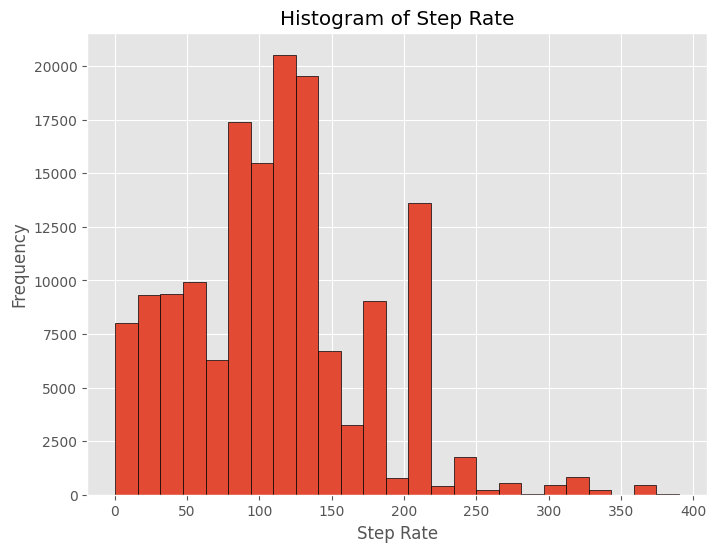

In [113]:
plt.figure(figsize=(8, 6))
plt.hist(df['step_rate'], bins=25, edgecolor='black')
plt.title('Histogram of Step Rate')
plt.xlabel('Step Rate')
plt.ylabel('Frequency')
plt.grid(True)

## Plot CGM and food logs

In [22]:
# Plot all days with good CGM and food log data for visualization
complete_days = set()

# for day in glucose_data['date'].unique():
for day in cgm_and_macros.index.unique():
  # extract loseit meal data for a given day
  meal_day = meals[meals['Date'] == day]
  glucose_day = glucose_data[glucose_data['date'] == day]
  if not meal_day.empty:
    complete_days.add(day)

    # Create a figure
    p = figure(width=600, height=400, x_axis_type='datetime',
                tools=['pan','xwheel_zoom', 'ywheel_zoom'],
                active_scroll='xwheel_zoom', x_axis_location='above')

    # Main CGM line
    p.line(glucose_day['time'], glucose_day['glucose'],
           line_width=2, line_color='gray', line_alpha=0.5)
    # # Main CGM line_filtered
    # p.line(glucose_day['time'], glucose_day['glucose_filtered'],
    #        line_width=2, line_color='black', line_alpha=1)

    # Mean CGM trace
    glucose_mean = np.mean(glucose_day['glucose'])
    mean_span = Span(location=glucose_mean, dimension='width',
                     line_color='red', line_width=1, line_alpha=1)
    p.add_layout(mean_span)

    # CGM Peaks
    peaks_df = identify_cgm_peaks(glucose_day)
    p.scatter(peaks_df['time'], peaks_df['peak_heights'],
              size=6, color='darkblue', alpha=0.7)

    # Meal bands
    for _, row in meal_day.iterrows():
      if row['True Time']:
        color = 'lightgreen'
      else:
        color = 'orange'
      meal_span = Span(location=row['DateTime'], dimension='height',
                       line_color=color, line_width=2, line_alpha=1)
      p.add_layout(meal_span)

      meal_shade = BoxAnnotation(left=row['DateTime'],
                                 right=row['DateTime'] + pd.Timedelta(hours=1),
                                 fill_color=color,
                                 fill_alpha=0.3)
      p.add_layout(meal_shade)

      label = Label(x=row['DateTime'], y=110, text=f"{row['Calories']:.2f}",
                    text_color='black', text_font_size="10pt",
                    angle=90, angle_units="deg",
                    background_fill_color="white",
                    background_fill_alpha=0.7)
      p.add_layout(label)

    # Customize the plot
    p.xaxis.axis_label = "Time"
    p.yaxis.axis_label = "Glucose"
    p.title.text = f"Day: {row['Date']}"
    p.title.align = "center"
    p.title.text_font_size = "20pt"
    p.title.text_font_style = "bold"

    # Show the plot
    show(p)
    print('\n\n')

print(f"There are {len(complete_days)} days: {complete_days}")




There are 44 days: {datetime.date(2022, 7, 14), datetime.date(2024, 7, 17), datetime.date(2024, 8, 5), datetime.date(2022, 4, 19), datetime.date(2024, 6, 18), datetime.date(2024, 7, 19), datetime.date(2024, 8, 6), datetime.date(2024, 8, 12), datetime.date(2024, 7, 22), datetime.date(2024, 8, 8), datetime.date(2024, 6, 25), datetime.date(2022, 12, 16), datetime.date(2024, 7, 21), datetime.date(2024, 7, 16), datetime.date(2024, 8, 4), datetime.date(2024, 8, 17), datetime.date(2024, 8, 9), datetime.date(2022, 12, 14), datetime.date(2023, 1, 16), datetime.date(2024, 6, 22), datetime.date(2024, 6, 29), datetime.date(2024, 7, 23), datetime.date(2022, 12, 17), datetime.date(2024, 8, 7), datetime.date(2024, 7, 18), datetime.date(2024, 6, 21), datetime.date(2023, 1, 18), datetime.date(2022, 12, 18), datetime.date(2023, 1, 17), datetime.date(2024, 8, 13), datetime.date(2022, 4, 20), datetime.date(2022, 12, 13), datetime.date(2024, 8, 2), datetime.date(2022, 7, 13), datetime.date(2022, 4, 18),

## Plot meals and CGM stats

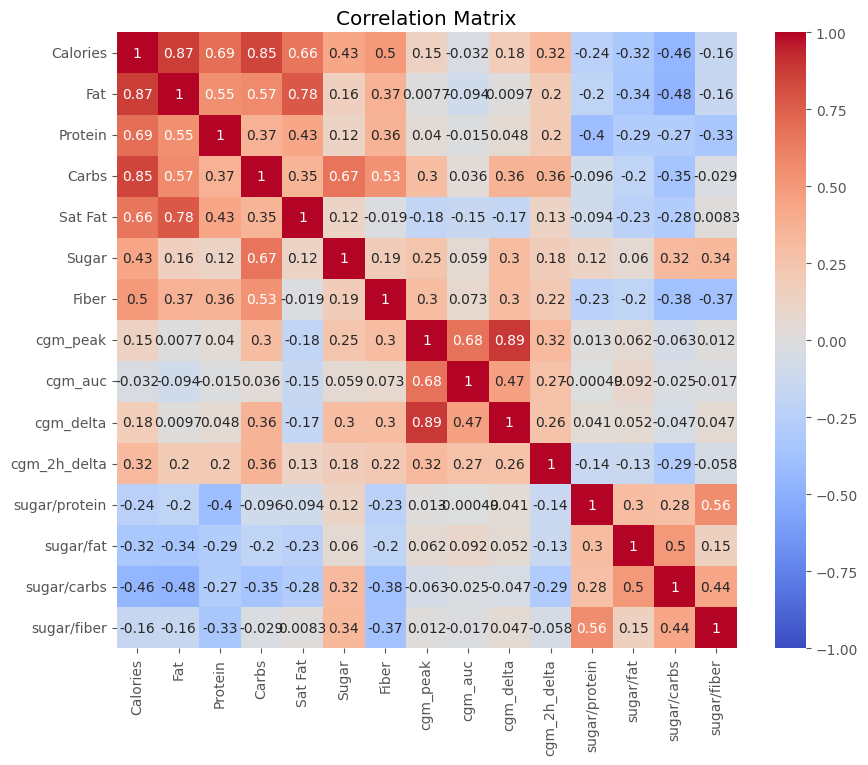

In [313]:
df = meals_cgm.copy()
df = df.drop(columns=['Name', 'Meal', 'Date', 'True Time', 'DateTime', 'Time'])
df['sugar/protein'] = df['Sugar'] / df['Protein']
df['sugar/fat'] = df['Sugar'] / df['Fat']
df['sugar/carbs'] = df['Sugar'] / df['Carbs']
df['sugar/fiber'] = df['Sugar'] / df['Fiber']


corr_matrix = df.corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show()

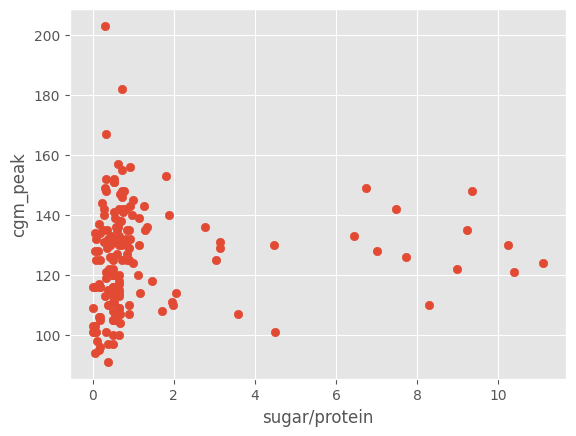

In [316]:
df = meals_cgm.copy()
df['sugar/protein'] = df['Sugar'] / df['Protein']
df['sugar/fat'] = df['Sugar'] / df['Fat']
df['sugar/carbs'] = df['Sugar'] / df['Carbs']
df['sugar/fiber'] = df['Sugar'] / df['Fiber']

df = df[df['sugar/protein'] < 12].copy()

x = 'sugar/protein'
y = 'cgm_peak'
plt.scatter(df[x], df[y])
plt.xlabel(x)
plt.ylabel(y)
plt.show()


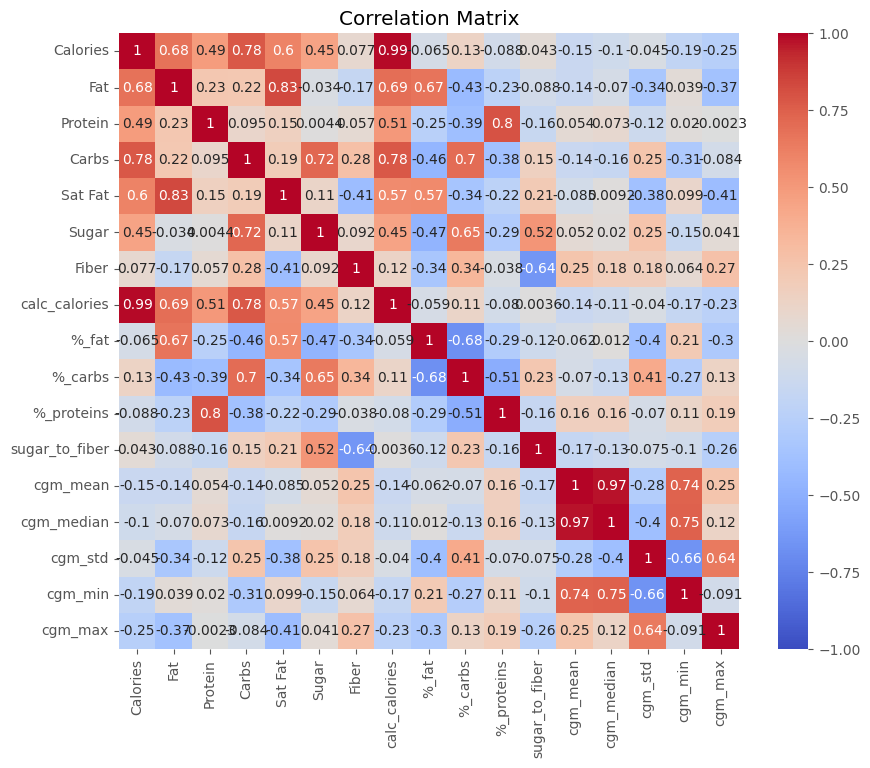

Top Correlations:


,Variable 1,Variable 2,Correlation,cross,sign
84,Sat Fat,cgm_max,0.410690,True,-1.0
167,%_carbs,cgm_std,0.410420,True,1.0
150,%_fat,cgm_std,0.397242,True,-1.0
82,Sat Fat,cgm_std,0.376086,True,-1.0
33,Fat,cgm_max,0.372713,True,-1.0
31,Fat,cgm_std,0.335242,True,-1.0
66,Carbs,cgm_min,0.306373,True,-1.0
152,%_fat,cgm_max,0.304705,True,-1.0
118,Fiber,cgm_max,0.271456,True,1.0
168,%_carbs,cgm_min,0.269941,True,-1.0


In [289]:
df = cgm_and_macros.copy()

# Calculate the correlation matrix
df = df.drop(columns=['Date'])
corr_matrix = df.corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show()

# Find the strongest pairwise correlations
corr_pairs = corr_matrix.unstack().reset_index()
corr_pairs.columns = ['Variable 1', 'Variable 2', 'Correlation']
corr_pairs['cross'] = corr_pairs['Variable 1'].apply(lambda x: x in daily_macros.columns) & corr_pairs['Variable 2'].apply(lambda x: x in cgm_daily_stats.columns)
corr_pairs = corr_pairs[corr_pairs['cross']]
corr_pairs['sign'] = np.sign(corr_pairs['Correlation'])
corr_pairs['Correlation'] = np.abs(corr_pairs['Correlation'])
corr_pairs = corr_pairs.drop_duplicates(subset=['Correlation'])  # Avoid duplicate pairs
corr_pairs = corr_pairs.sort_values(by='Correlation', ascending=False)  # Sort by absolute correlation

print("Top Correlations:")
corr_pairs

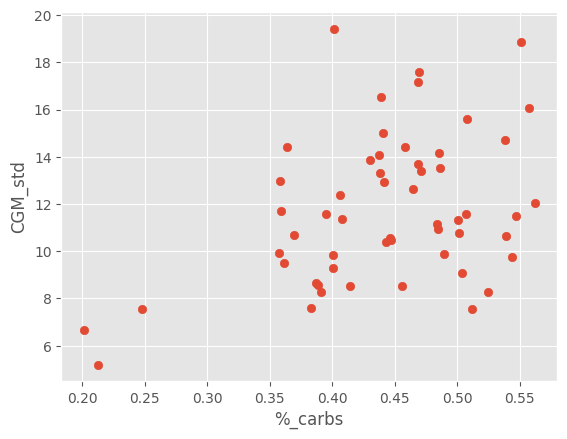

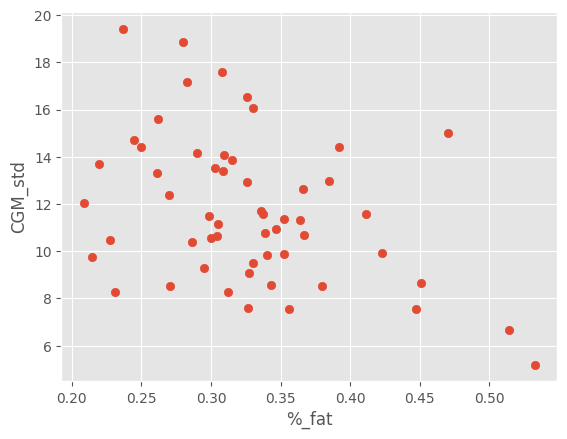

In [301]:
plt.scatter(cgm_and_macros['%_carbs'], cgm_and_macros['cgm_std'])
plt.xlabel('%_carbs')
plt.ylabel('CGM_std')
plt.show()

plt.scatter(cgm_and_macros['%_fat'], cgm_and_macros['cgm_std'])
plt.xlabel('%_fat')
plt.ylabel('CGM_std')
plt.show()

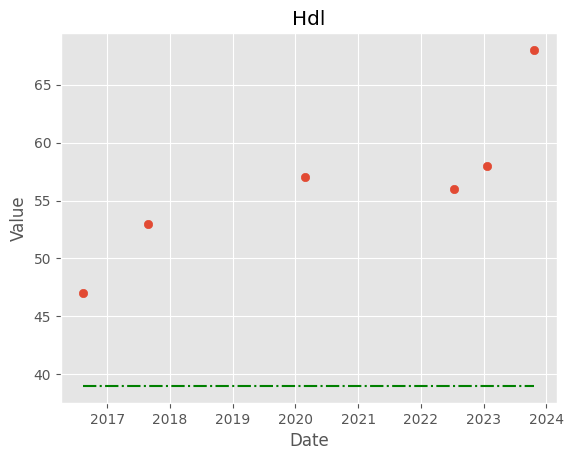

In [34]:
analyte_name = 'hdl' # @param ['albumin', 'red blood cell count', 'glucose', 'ldl', 'hdl', 'white blood cell count', 'platelets', 'triglycerides', 'vitamin b12', 'hba1c', 'vitamin d', 'cholesterol', 'testosterone']
analyte = df[df['lab'] == analyte_name]
analyte = analyte.sort_values(by=['date'])
analyte['low_ref'] = pd.to_numeric(analyte['low_ref'], errors='coerce')
analyte['low_ref'] = analyte['low_ref'].ffill()
analyte['high_ref'] = pd.to_numeric(analyte['high_ref'], errors='coerce')
analyte['high_ref'] = analyte['high_ref'].ffill()
plt.scatter(analyte['date'], analyte['value'])
plt.plot(analyte['date'], analyte['low_ref'], '-.', color='green')
plt.plot(analyte['date'], analyte['high_ref'], '-.', color='green')
plt.title(analyte_name.capitalize())
plt.xlabel('Date')
plt.ylabel('Value')
plt.show()

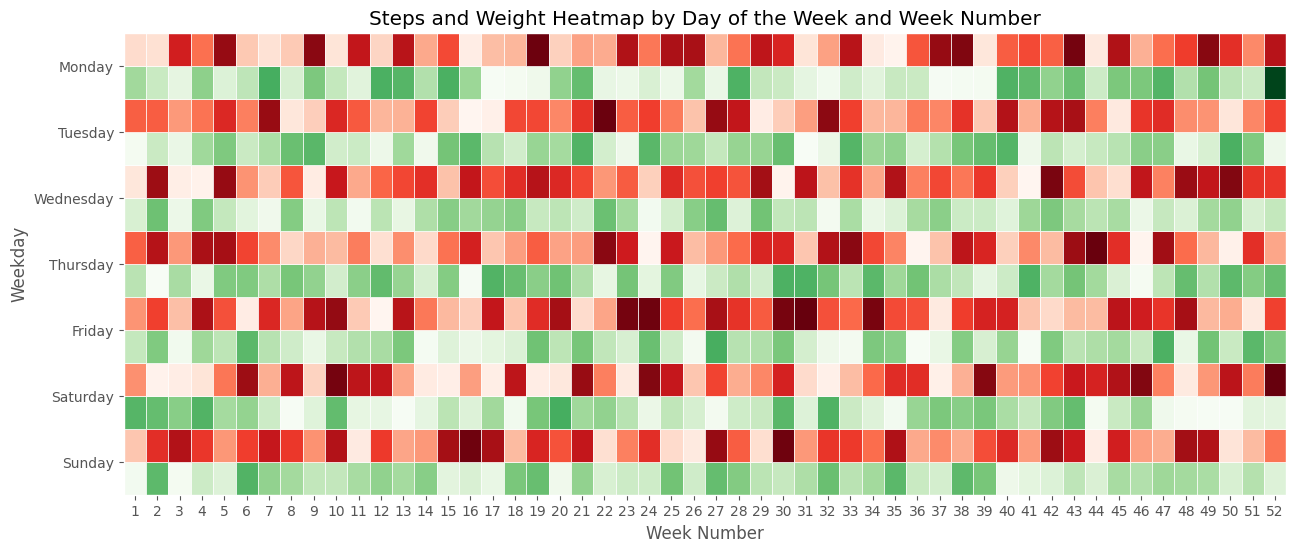

In [84]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.patches as patches

# Example data generation
dates = pd.date_range(start='2023-01-01', end='2023-12-31', freq='D')
steps = np.random.randint(0, 10000, size=len(dates))
weights = np.random.uniform(60, 100, size=len(dates))

# Create DataFrame
df = pd.DataFrame({'date': dates, 'steps': steps, 'weight': weights})
df['weekday'] = df['date'].dt.day_name()
df['week'] = df['date'].dt.isocalendar().week

# Define the correct order for weekdays
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
df['weekday'] = pd.Categorical(df['weekday'], categories=weekday_order, ordered=True)

# Create pivot tables for steps and weight
steps_pivot = df.pivot_table(index='weekday', columns='week', values='steps', aggfunc='sum', fill_value=0)
weight_pivot = df.pivot_table(index='weekday', columns='week', values='weight', aggfunc='mean', fill_value=0)

# Normalize the data to scale the colors
norm_steps = plt.Normalize(vmin=steps_pivot.min().min(), vmax=steps_pivot.max().max())
norm_weight = plt.Normalize(vmin=weight_pivot.min().min(), vmax=weight_pivot.max().max())

# Create the plot
fig, ax = plt.subplots(figsize=(15, 6))

# Define the grid dimensions
num_rows = len(steps_pivot.index)
num_cols = len(steps_pivot.columns)

# Iterate through each cell in the grid
for i in range(num_rows):
    for j in range(num_cols):
        # Get the step and weight values
        step_value = steps_pivot.iloc[i, j]
        weight_value = weight_pivot.iloc[i, j]

        # Get the normalized color values for both steps and weight
        step_color = plt.cm.Greens(norm_steps(step_value))
        weight_color = plt.cm.Reds(norm_weight(weight_value))

        # Create the top half rectangle for steps (green)
        rect_top = patches.Rectangle((j, num_rows - i - 1 + 0.5), 1, 0.5, facecolor=step_color, edgecolor='white')
        ax.add_patch(rect_top)

        # Create the bottom half rectangle for weight (red)
        rect_bottom = patches.Rectangle((j, num_rows - i - 1), 1, 0.5, facecolor=weight_color, edgecolor='white')
        ax.add_patch(rect_bottom)

# Set the axis limits and labels
ax.set_xlim(0, num_cols)
ax.set_ylim(0, num_rows)
ax.set_xticks(np.arange(num_cols) + 0.5)
ax.set_yticks(np.arange(num_rows) + 0.5)
ax.set_xticklabels(steps_pivot.columns)
ax.set_yticklabels(steps_pivot.index)

# Adjust the plot aesthetics
ax.invert_yaxis()
ax.set_title('Steps and Weight Heatmap by Day of the Week and Week Number')
ax.set_xlabel('Week Number')
ax.set_ylabel('Weekday')

plt.show()
